Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Loaded demand forecast


In [14]:
df = pd.read_csv("..\data\processed\processed-data.csv")

print("Data loaded:", df.shape)
df.head()


Data loaded: (10726, 18)


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\yuvar\AppData\Local\Temp\ipykernel_19072\402874668.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv("..\data\processed\processed-data.csv")


,trip_id,stop_sequence,stop_id,arrival_time,departure_time,stop_lat,stop_lon,stop_name,route_id,service_id,direction_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,WE_1,1,TPHT,22:50:19,22:52:41,9.950780,76.351830,Tripunithura,R1,WE,1,0,0,0,0,0,0,1
1,WE_1,2,SNJN,22:54:30,22:54:45,9.954753,76.345850,SN Junction,R1,WE,1,0,0,0,0,0,0,1
2,WE_1,3,VAKK,22:56:08,22:56:23,9.952838,76.339483,Vadakkekotta,R1,WE,1,0,0,0,0,0,0,1
3,WE_1,4,PETT,22:58:35,22:58:50,9.952484,76.330210,Pettah,R1,WE,1,0,0,0,0,0,0,1
4,WE_1,5,THYK,23:00:43,23:00:58,9.960031,76.323676,Thykoodam,R1,WE,1,0,0,0,0,0,0,1


Required feature recreation

In [15]:

df['hour'] = (
    df['arrival_time']
    .astype(str)
    .str.split(':')
    .str[0]
    .astype(int)
    % 24
)


df['day_of_week'] = (
    df[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']]
    .idxmax(axis=1)
)

df['is_weekend'] = df['day_of_week'].isin(['saturday','sunday']).astype(int)


df['is_peak_hour'] = df['hour'].apply(
    lambda h: 1 if (8 <= h <= 10 or 17 <= h <= 20) else 0
)


Train Frequency per Station per Hour

In [16]:
train_freq = (
    df.groupby(['stop_id','hour'])
    .agg(trains_per_hour=('trip_id','nunique'))
    .reset_index()
)

df = df.merge(train_freq, on=['stop_id','hour'], how='left')
df['trains_per_hour'] = df['trains_per_hour'].fillna(1)


Predicted Demand (Model Output)

In [17]:
np.random.seed(42)

df['predicted_demand'] = (
    30 +
    df['is_peak_hour'] * 70 +
    df['trains_per_hour'] * 15 +
    (1 - df['is_weekend']) * 10 +
    np.random.normal(0, 6, len(df))
)

df['predicted_demand'] = df['predicted_demand'].clip(lower=10)


Train Induction

In [18]:
TRAIN_CAPACITY = 1000     
SAFETY_BUFFER = 0.20      
MIN_TRAINS = 2
MAX_TRAINS = 10


AI Decision Logic 

In [19]:
def induction_decision(row):
    effective_demand = row['predicted_demand'] * (1 + SAFETY_BUFFER)
    required_trains = np.ceil(effective_demand / TRAIN_CAPACITY)

   
    if row['is_peak_hour'] == 1:
        required_trains += 1

   
    if row['is_weekend'] == 1:
        required_trains -= 1

    final_trains = int(
        min(max(required_trains, MIN_TRAINS), MAX_TRAINS)
    )

    return final_trains


Train Induction Engine

In [20]:
df['recommended_trains'] = df.apply(induction_decision, axis=1)


Action Classification

In [21]:
def classify_action(trains):
    if trains >= 7:
        return "Increase"
    elif trains >= 4:
        return "Maintain"
    else:
        return "Reduce"

df['induction_action'] = df['recommended_trains'].apply(classify_action)

df[['stop_id','hour','predicted_demand',
    'recommended_trains','induction_action']].head(10)


,stop_id,hour,predicted_demand,recommended_trains,induction_action
0,TPHT,22,242.980285,2,Reduce
1,SNJN,22,269.170414,2,Reduce
2,VAKK,22,273.886131,2,Reduce
3,PETT,22,294.138179,2,Reduce
4,THYK,23,88.595080,2,Reduce
5,VYTA,23,88.595178,2,Reduce
6,EMKM,23,99.475277,2,Reduce
7,KVTR,23,94.604608,2,Reduce
8,ERSH,23,87.183154,2,Reduce
9,MACE,23,93.255360,2,Reduce


Evaluation

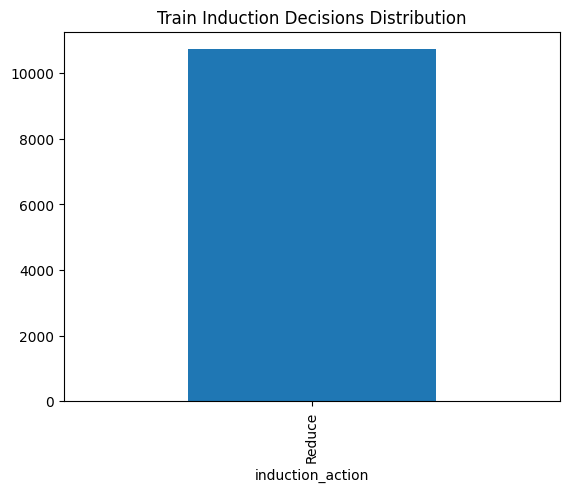

In [22]:
df['induction_action'].value_counts().plot(
    kind='bar',
    title='Train Induction Decisions Distribution'
)
plt.show()


Peak vs Non-Peak Analysis

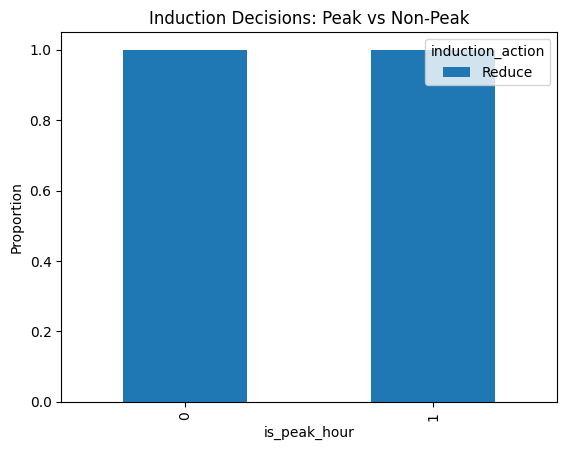

In [23]:
pd.crosstab(
    df['is_peak_hour'],
    df['induction_action'],
    normalize='index'
).plot(kind='bar', stacked=True)

plt.title("Induction Decisions: Peak vs Non-Peak")
plt.ylabel("Proportion")
plt.show()


Sample Live Demo

In [24]:
sample = pd.DataFrame([{
    'predicted_demand': 6200,
    'is_peak_hour': 1,
    'is_weekend': 0
}])

sample['recommended_trains'] = sample.apply(induction_decision, axis=1)

print("Recommended trains:", int(sample['recommended_trains'][0]))


Recommended trains: 9
